In [46]:
import osmnx as ox
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import json
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

CONFIG = "config/RO/Iasi/Iasi.json"

WALKING_SPEED_MS = 0.8 # meters per second
INFRASTRUCTURE_CUTOFF_DIST = 20 # meters

# Source: https://wiki.openstreetmap.org/wiki/Key:building?uselang=en-GB#Accommodation
# Source: https://wiki.openstreetmap.org/wiki/Key:shop / https://wiki.openstreetmap.org/wiki/Key:amenity?uselang=en-GB
RESIDENTIAL_TAGS = {'building': ['apartments', 'bungalow', 'cabin', 'detached', 'dormitory', 'house', 'residential', 'semidetached_house', 'yes']}

# Structure: (<feature name>, <max score>, <filtering tags>)
AMENITY_TAGS = [
    # Public Transport
    ('public_transport', 5, {'public_transport': True}),
    # Grocer
    ('grocer', 3, {'shop': ['supermarket', 'butcher', 'cheese', 'convenience', 'deli', 'dairy', 'greengrocer', 'health_food', 'department_store', 'general']}),
    # Pharmacy
    ('pharmacy', 3, {'shop': ['chemist'], 'amenity': ['pharmacy'], 'healthcare': ['pharmacy']}),
    # Bank
    ('bank', 2, {'amenity': ['bank', 'atm'], 'atm': True}),
    # Playground
    ('playground', 2, {'leisure': ['playground', 'pitch', 'track']}),
    # General Store
    ('general_store', 2, {'shop': ['supermarket', 'convenience', 'deli', 'greengrocer', 'health_food', 'department_store', 'general']}),
    # Clothes Store
    ('clothes_store', 2, {'shop': ['clothes', 'shoes']}),
    # Kindergarten
    ('kindergarten', 2, {'amenity': ['kindergarten'], 'building': ['kindergarten']}),
    # School
    ('school', 4, {'amenity': ['school'], 'building': ['school']}),
    # Restaurant
    ('restaurant', 2, {'amenity': ['restaurant', 'food_court', 'fast_food']}),
    # Cafe
    ('cafe', 2, {'amenity': ['cafe'], 'scop': ['coffee']}),
    # Dry Cleaner
    ('cleaner', 2, {'shop': ['dry_cleaning', 'laundry']}),
    # Beauty and grooming
    ('beauty', 2, {'shop': ['beauty', 'hairdresser']}),
    # Outdoor physical activities
    ('outdoor_sports', 2, {'leisure': ['disc_golf_course', 'dog_park', 'fishing', 'fitness_station', 'golf_course', 'horse_riding', 'pitch', 'stadium', 'track', 'stadium', 'swimming_area', 'water_park']}),
    # Indoor physical activities
    ('indoor_sports', 2, {'leisure': ['bowling_alley', 'dance', 'fitness_centre', 'ice_rink', 'sports_centre', 'sports_hall', 'swimming_pool', 'trampoline_park', 'water_park'], 'sport': ['gym']}),
    # Entertainment venue
    ('entertainment', 1, {
        'leisure': ['adult_gaming_centre', 'amusement_arcade', 'dance', 'miniature_golf'], 
        'amenity': ['arts_centre', 'casino', 'cinema', 'community_centre', 'conference_centre', 'events_venue', 'exhibition_centre', 'music_venue', 'nightclub', 'social_centre', 'theatre']
        }),
    # Hospital or clinic
    ('hospital', 1, {'amenity': ['clinic', 'hospital', 'doctors']}),
    # Bookstore or library
    ('bookstore', 1, {'shop': ['books'], 'amenity': ['library']}),
    # Museum
    ('museum', 1, {'tourism': ['museum', 'aquarium', 'zoo']}),
    # Art Gallery
    ('art_gallery', 1, {'tourism': ['artwork', 'gallery']}),
    # Park
    ('park', 2, {'leisure': ['park']}),
]

ox.config(useful_tags_way=['width', 'lit', 'maxspeed'])


In [116]:
config = json.load(open(CONFIG, 'r'))

place_id = config['placeId']
default_maxspeed = config.get('defaults', {}).get('maxspeed', 50.0)
default_sidewalk_width = config.get('defaults', {}).get('sidewalk_width', 1.0)
default_sidewalk_lit = config.get('defaults', {}).get('sidewalk_lit', "no")
default_bikepath_width = config.get('defaults', {}).get('bike_width', 1.0)
default_bikepath_lit = config.get('defaults', {}).get('bike_lit', "no")

C:\Users\Catalin\AppData\Local\Temp\ipykernel_11768\1505660611.py:1: ResourceWarning: unclosed file <_io.TextIOWrapper name='config/RO/Iasi/Iasi.json' mode='r' encoding='cp1252'>
  config = json.load(open(CONFIG, 'r'))


In [48]:
def safe_query_graph(network_type=None, custom_filter=None):
    try:
        df = ox.graph_from_place(place_id, custom_filter=custom_filter, network_type=network_type, retain_all=True)
        return ox.project_graph(df)
    except ValueError as ex:
        print (ex)
        return nx.multidigraph.MultiDiGraph()
    
def safe_query_locations(tags):
    try:
        df = ox.features_from_place(place_id, tags).reset_index()
        df = ox.projection.project_gdf(df)
        return df
    except ox._errors.InsufficientResponseError as ex:
        return pd.DataFrame()


df_residential = ox.features_from_place(place_id, RESIDENTIAL_TAGS)
df_residential = ox.projection.project_gdf(df_residential)
df_residential = df_residential[df_residential['shop'].isnull()]
df_residential = df_residential[df_residential['amenity'].isnull()]
df_residential = df_residential[df_residential['leisure'].isnull()]
df_residential = df_residential[df_residential['tourism'].isnull()]
df_residential = df_residential[df_residential['office'].isnull()]
df_residential = df_residential.reset_index()

df_path_walk = safe_query_graph(network_type='walk')
df_path_bike = nx.compose(
    safe_query_graph(custom_filter='["highway"~"cycleway"]'), 
    safe_query_graph(custom_filter='["cycleway"~"track"]')
)
df_path_drive = safe_query_graph(network_type='drive')

df_residential['edges_walk'], df_residential['edges_walk_dist'] = ox.nearest_edges(df_path_walk, df_residential.centroid.x, df_residential.centroid.y, return_dist=True)
df_residential['edges_bike'], df_residential['edges_bike_dist'] = ox.nearest_edges(df_path_bike, df_residential.centroid.x, df_residential.centroid.y, return_dist=True)
df_residential['edges_drive'], df_residential['edges_drive_dist'] = ox.nearest_edges(df_path_drive, df_residential.centroid.x, df_residential.centroid.y, return_dist=True)

df_amenities = []

for feature_name, score, tags in AMENITY_TAGS:
    print (f"Querying: {feature_name}")
    df = safe_query_locations(tags)
    df_amenities.append((feature_name, score, df))

Querying: public_transport
Querying: grocer
Querying: pharmacy
Querying: bank
Querying: playground
Querying: general_store
Querying: clothes_store
Querying: kindergarten
Querying: school
Querying: restaurant
Querying: cafe
Querying: cleaner
Querying: beauty
Querying: outdoor_sports
Querying: indoor_sports
Querying: entertainment
Querying: hospital
Querying: bookstore
Querying: museum
Querying: art_gallery
Querying: park


<Figure size 640x480 with 0 Axes>

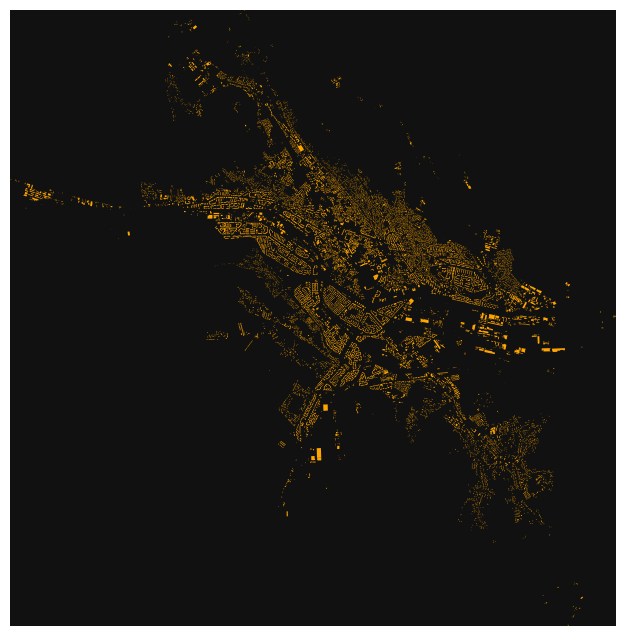

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [49]:
plt.figure()

ox.plot_footprints(df_residential)
# ox.plot_graph(df_path_bike)

In [115]:
def distance_to_score(distance):
    min_time = distance / WALKING_SPEED_MS / 60

    if min_time > 25:
        return 0

    return min((25 - min_time) / 20, 1)

def sidewalk_score(node):
    total_score = 0

    if node['edges_walk_dist'] < INFRASTRUCTURE_CUTOFF_DIST:
        closest_street = df_path_walk.edges[node['edges_walk']]
        sidewalk_width = float(closest_street.get('width', default_sidewalk_width))

        if sidewalk_width >= 1:
            total_score += 3

        if sidewalk_width >= 2:
            total_score += 1

        if closest_street.get("lit", default_sidewalk_lit) == 'yes':
            total_score += 1 

    return total_score

def bike_path_score(node):
    total_score = 0

    if node['edges_bike_dist'] < INFRASTRUCTURE_CUTOFF_DIST:
        closest_path = df_path_bike.edges[node['edges_bike']]

        if float(closest_path.get('width', default_bikepath_width)) >= 1.5:
            total_score += 3

        if closest_path.get("lit", default_bikepath_lit) == 'yes':
            total_score += 1 

    return total_score

def drive_path_score(node):
    total_score = 0

    if node['edges_drive_dist'] < INFRASTRUCTURE_CUTOFF_DIST:
        closest_street = df_path_drive.edges[node['edges_drive']]
        max_speed = closest_street.get('maxspeed', default_maxspeed)

        if type(max_speed) is list:
            max_speed = max_speed[0]

        if type(max_speed) is str:
            max_speed = max_speed.lower()

        if max_speed in config["parameters"]:
            max_speed = config["parameters"][max_speed]
        else:
            max_speed = float(max_speed)

        if max_speed <= 30:
            total_score += 2

        if max_speed <= 15:
            total_score += 1 

    return total_score

df_residential["lcs_sidewalk"] = df_residential.apply(sidewalk_score, axis=1)
df_residential["lcs_bike_path"] = df_residential.apply(bike_path_score, axis=1)
df_residential["lcs_drive_path"] = df_residential.apply(drive_path_score, axis=1)

for feature_name, score, df in df_amenities:
    break
    df_joined = df_residential.sjoin_nearest(df, distance_col='dist', how='left')
    df_dist = score * df_joined['dist'].apply(distance_to_score)
    df_dist = df_dist.groupby(df_dist.index).min()
    df_residential[f"lcs_{feature_name}"] = df_dist

df_residential['lcs'] = 0

for col in [col for col in df_residential.columns if col.startswith("lcs_")]:
    df_residential['lcs'] += df_residential[col]
    

ValueError: could not convert string to float: 'ro:urban'

In [110]:
def plot_feature(score_column, max_score = 5):
    cmap = mpl.colormaps['RdYlGn']
    return ox.plot_footprints(df_residential, color=cmap((df_residential[score_column] * 1.0 / max_score)), bgcolor='black', figsize=(8, 8), show=False)


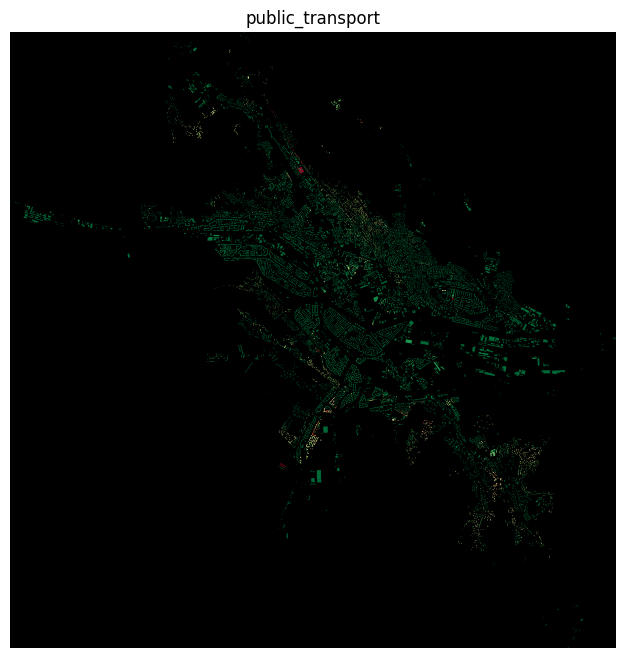

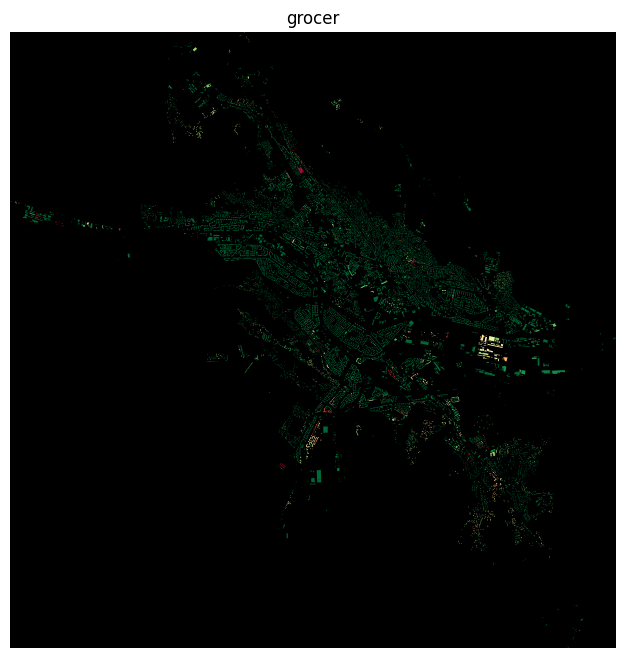

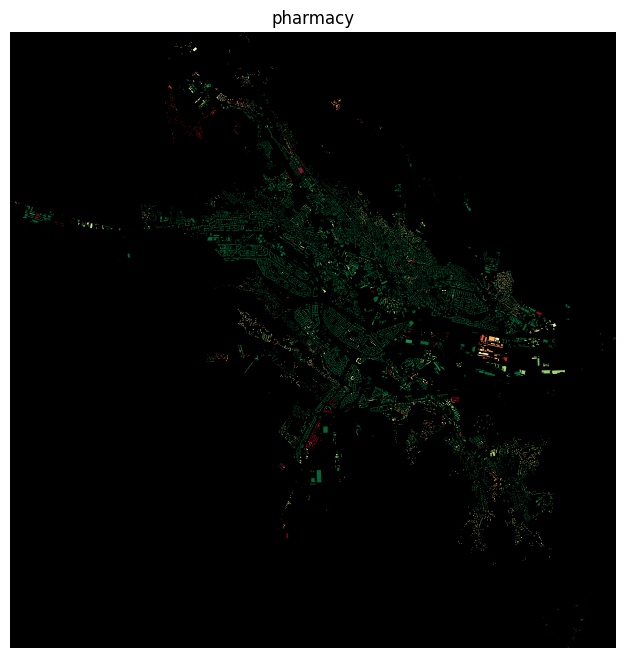

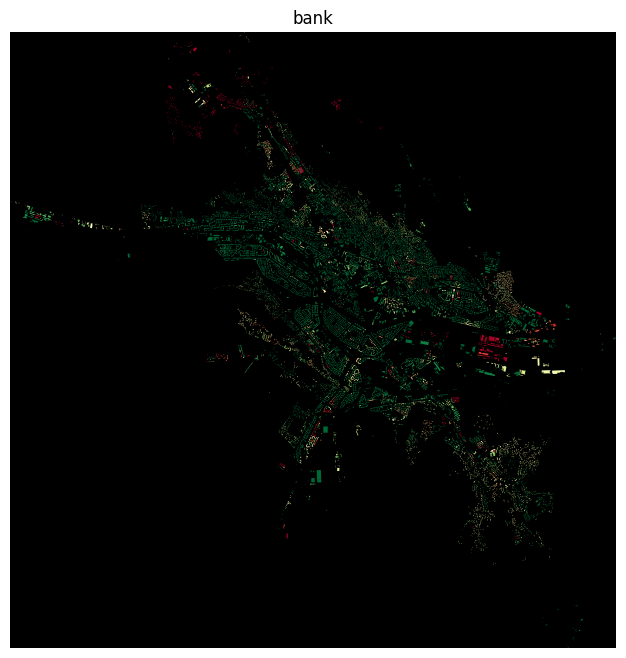

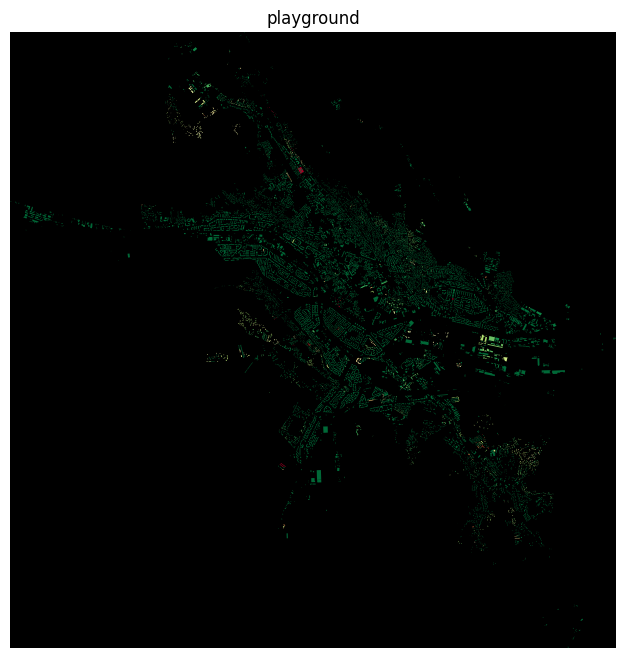

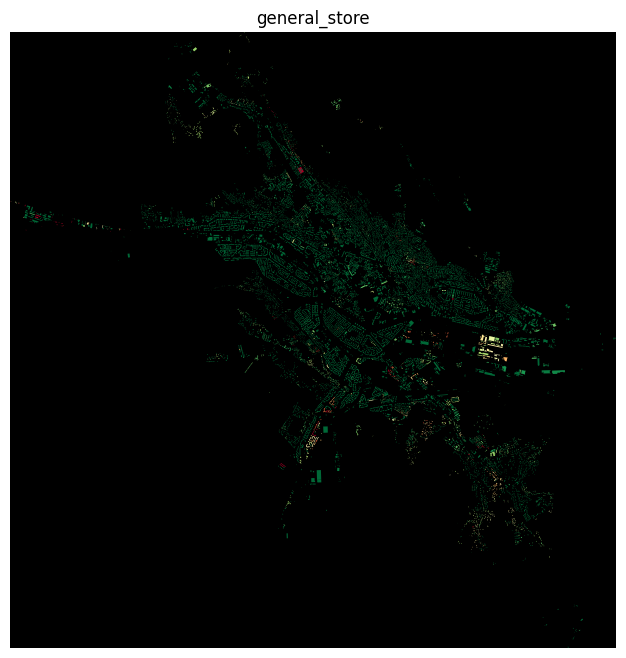

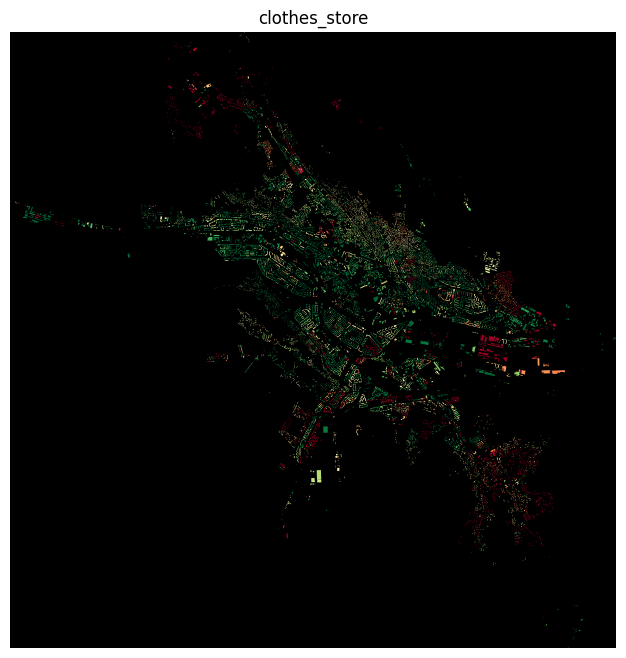

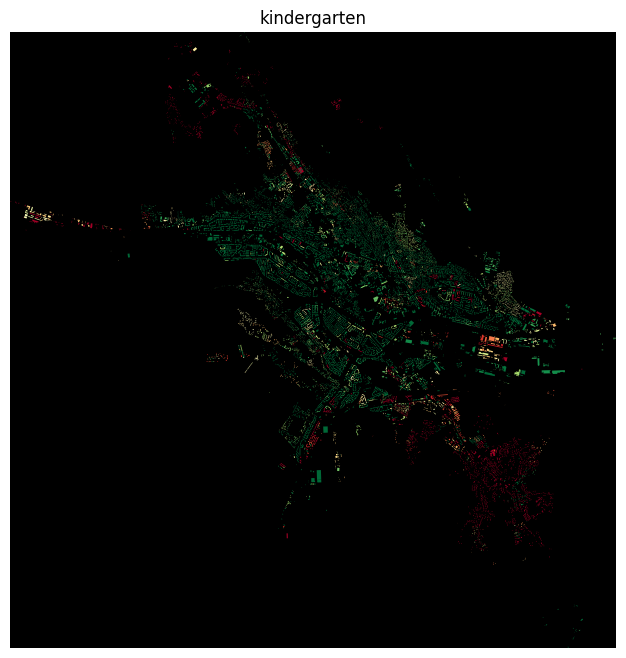

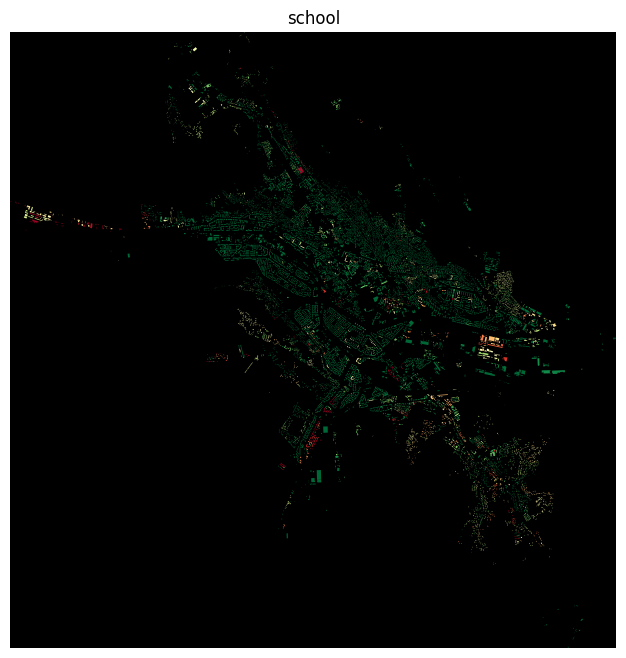

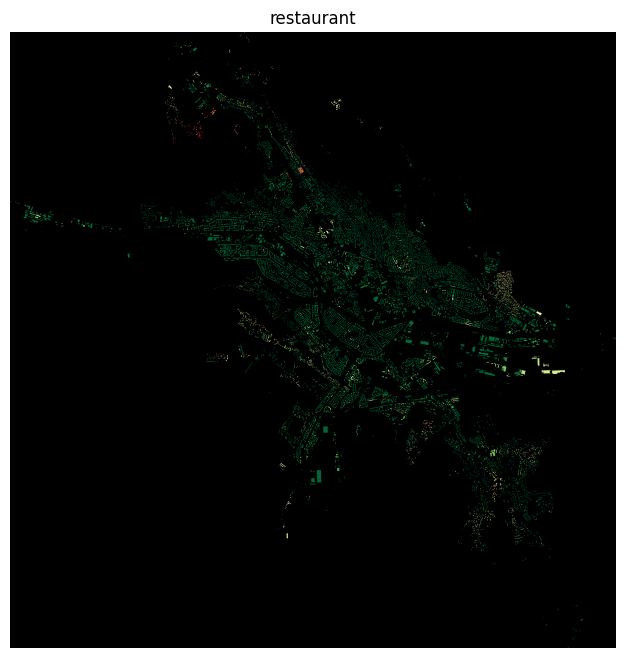

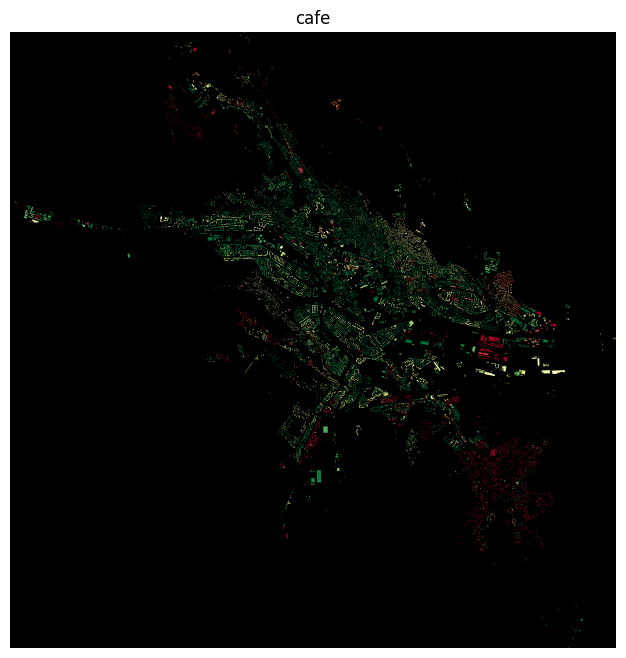

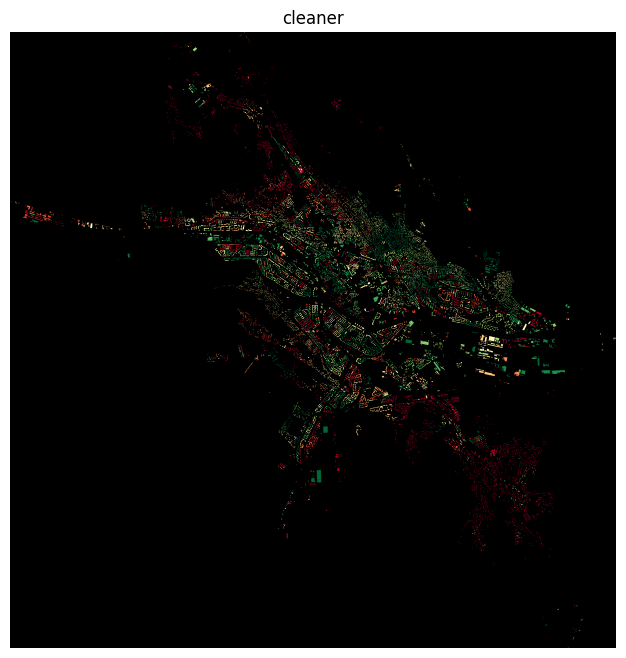

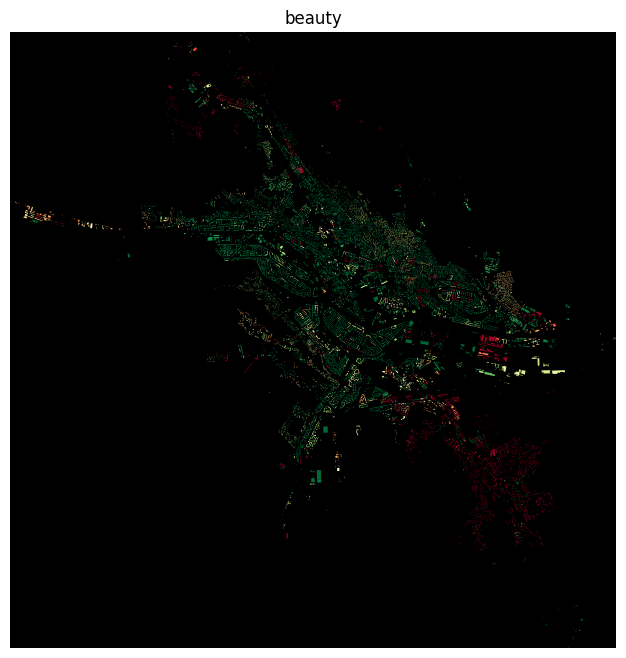

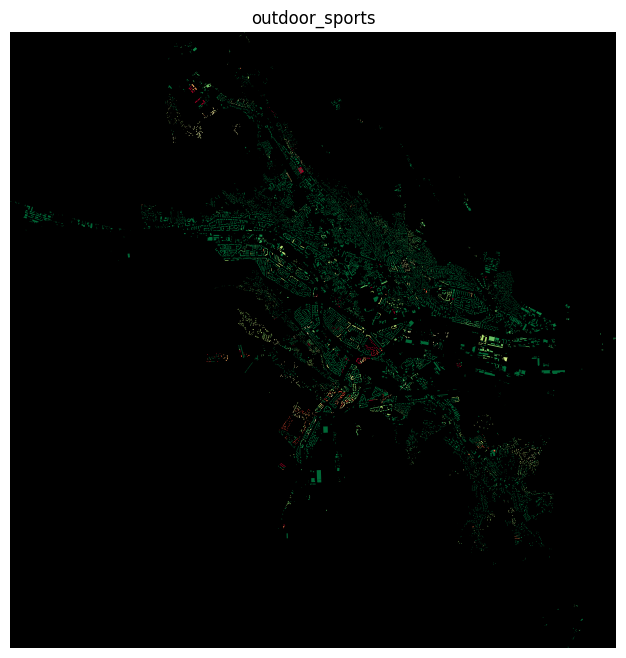

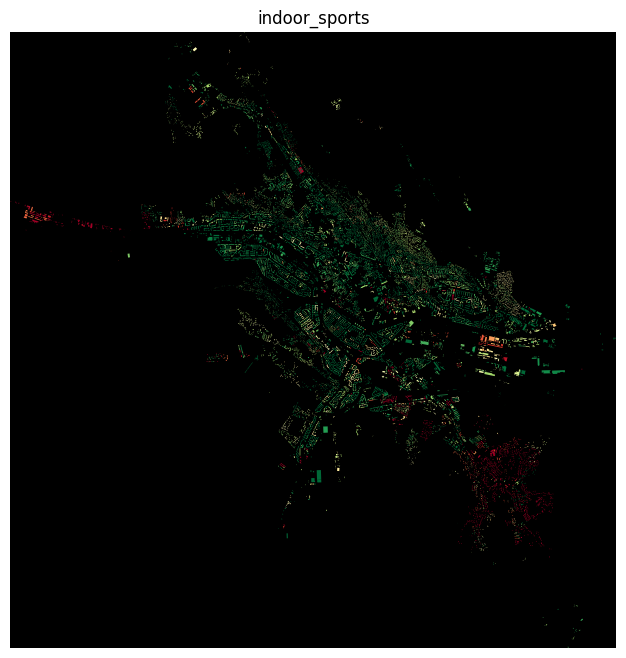

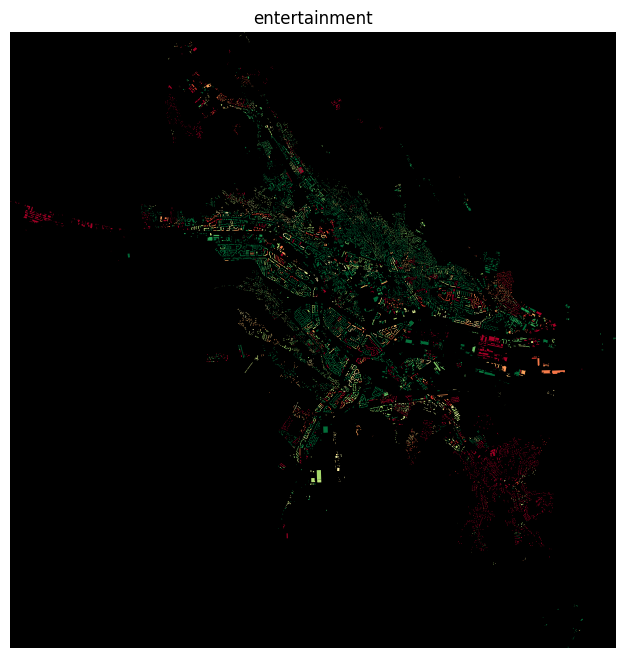

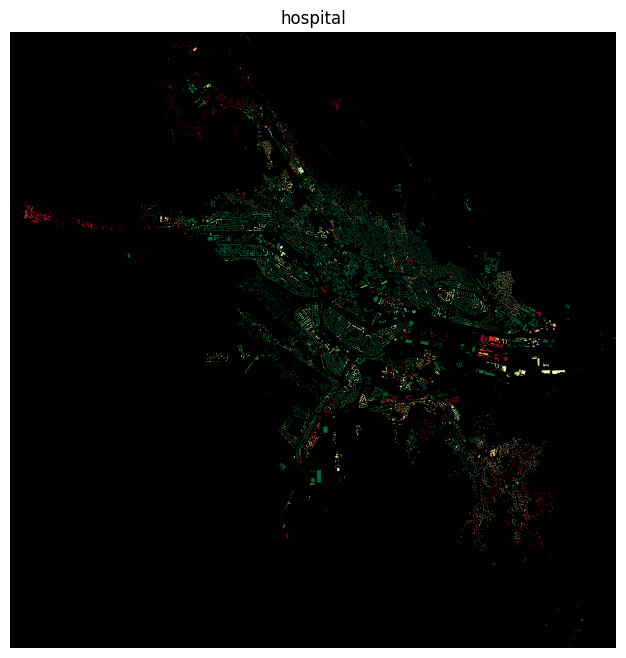

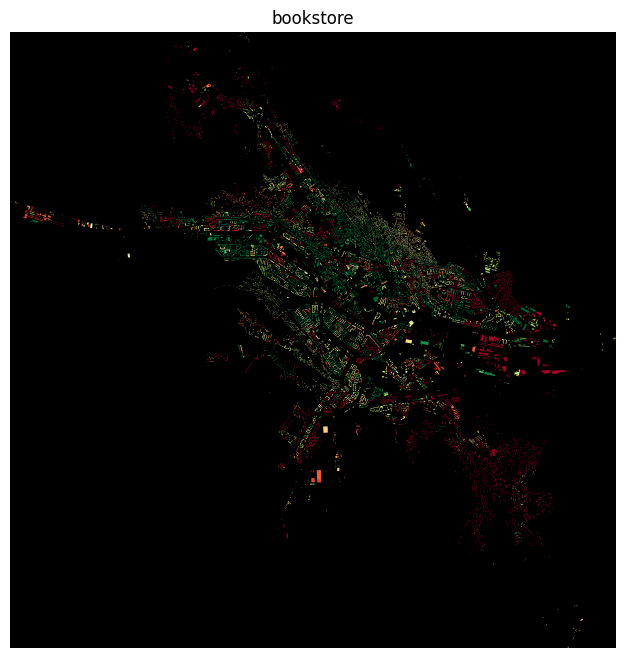

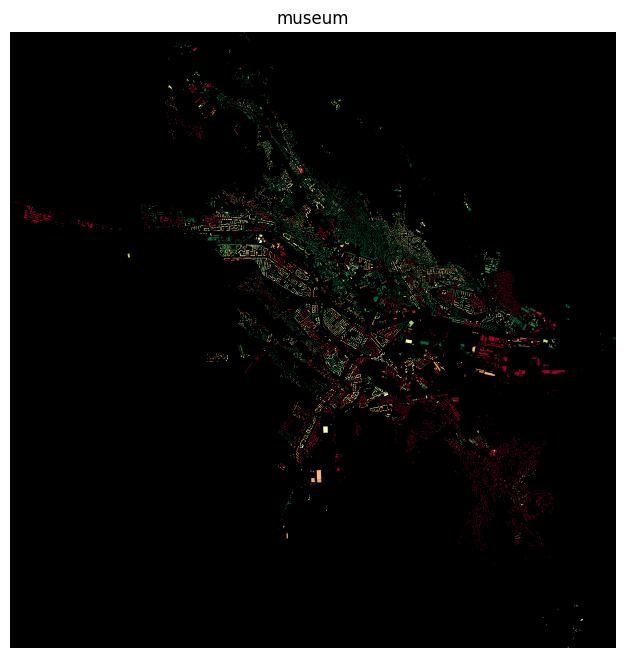

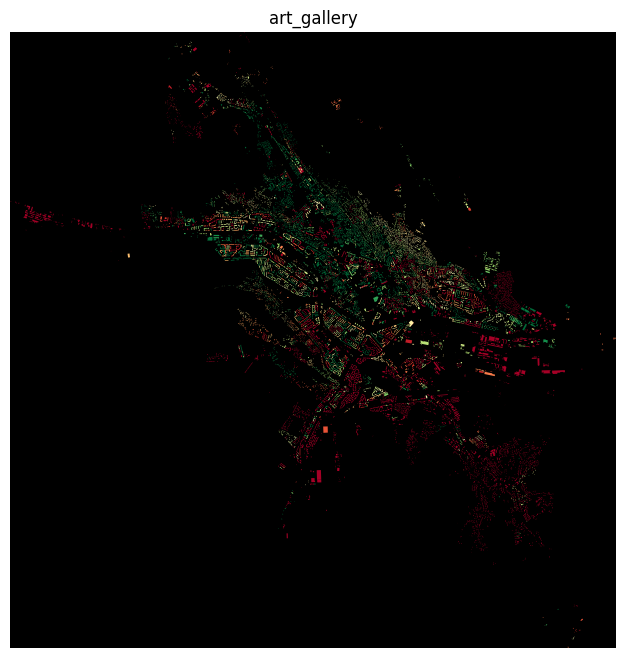

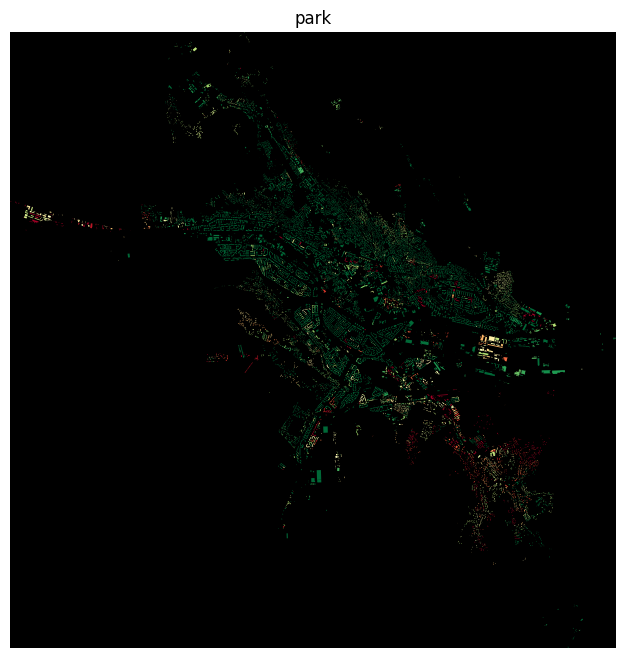

In [111]:
for feature_name, score, df in df_amenities:
    fig, ax = plot_feature(f'lcs_{feature_name}', max_score=score)
    ax.set_title(feature_name)
    plt.show()

<AxesSubplot: >

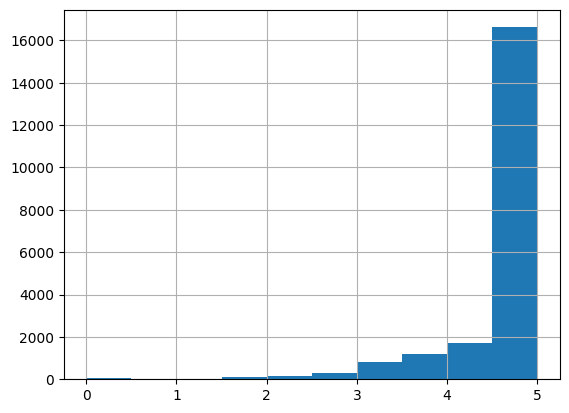

In [59]:
df_residential['lcs_public_transport'].hist()

In [92]:
df_amenities[11][2].shape

(11, 24)